

# 1，个人赛题理解

> 第一次参加语音类别的比赛，使用的网络模型很简单，我的分数主要来自特征提取

  本次赛题的数据是wav的音频数据，首先需要对数据集进行采样然后区梅尔倒谱特征来作为输入特征，还有其他的各种特征也可以提取出来一起使用，由于时间和技术原因就没有加了。

  然后是模型选择，直接上了多层卷积串联多层全连接网络。



# 2，赛事数据集解释

数据集一共有20种类别，其中训练集7000个，测试集2000个，其中训练集每个类别的数量不相同，可以做简单的类别不均衡处理（但我没做）。每个数据大概都在5秒左右，是较短的音频数据。

# 3，解决方案分享

> 解决方案主要两个部分：特征提取+神经网络

特征提取：对音频数据提取出128个梅尔倒谱特征，然后处理成16x8的图像数据作为输入数据

神经网络：简单5层卷积网络串联四层全连接网络进行分类；混入了部分dropout层防止过拟合；激活函数全部选用Tanh，方便收敛。

代码

1.GitHub：https://github.com/Deng-deng-deng-deng/tianchi-Food-voice-recognition-top15

2.notebook后面部分

# 4，参赛感受

这次运气很好，但是看了一些论文，由于有其他事要做就没有进行复现进行实验。

本次比赛最重要的地方我觉得是特征提取，特征提取好了，就可以用成熟的分类算法进行分类了。

# 5，建议

多动手，多看论文和经验文章。
# 6、notebook步骤简介
## 1.数据集下载
## 2.数据预处理
## 3.模型训练
## 4.模型预测

## --------------分割线------------
## 1.数据集下载

In [ ]:
!wget http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531887/train.zip

--2021-06-04 00:24:23--  http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531887/train.zip
Resolving tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.com)... 118.31.232.194
Connecting to tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.com)|118.31.232.194|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3793765027 (3.5G) [application/zip]
Saving to: ‘train.zip’

train.zip             5%[>                   ] 208.81M  11.4MB/s    eta 4m 37s 

In [ ]:
!unzip -qq train.zip
!\rm train.zip

## 2.数据预处理

In [2]:
!pip install --upgrade pip
!pip install -U librosa --user

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
  Using cached https://mirrors.cloud.aliyuncs.com/pypi/packages/cd/82/04e9aaf603fdbaecb4323b9e723f13c92c245f6ab2902195c53987848c78/pip-21.1.2-py3-none-any.whl (1.5 MB)
Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
  Using cached https://mirrors.cloud.aliyuncs.com/pypi/packages/54/19/a0e2bdc94bc0d1555e4f9bc4099a0751da83fa6e1e6157ec005564f8a98a/librosa-0.8.1-py3-none-any.whl (203 kB)
  Using cached audioread-2.1.9-py3-none-any.whl
  Using cached resampy-0.2.2-py3-none-any.whl
  Using cached https://mirrors.cloud.aliyuncs.com/pypi/packages/4a/c1/e7fdbfc886a9d9c11767533903db0d816c0f656fd6029f4a061742893694/numba-0.53.1-cp36-cp36m-manylinux2014_x86_64.whl (3.4 MB)
  Using cached https://mirrors.cloud.aliyuncs.com/pypi/packages/55/85/70c6602b078bd9e6f3da4f467047e906525c355a4dacd4f71b97a35d9897/joblib-1.0.1-py3-none-any.whl (303 

In [1]:
#导出包
import os 
import glob
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.utils.data as Data
import torch.nn as nn
import copy
import time

In [2]:
#设置种子
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
# 设置随机数种子
setup_seed(2021)

In [3]:
#数据预处理

feature = []
label = []
# 建立类别标签，不同类别对应不同的数字。
label_dict = {'aloe': 0, 'burger': 1, 'cabbage': 2,'candied_fruits':3, 'carrots': 4, 'chips':5,
                  'chocolate': 6, 'drinks': 7, 'fries': 8, 'grapes': 9, 'gummies': 10, 'ice-cream':11,
                  'jelly': 12, 'noodles': 13, 'pickles': 14, 'pizza': 15, 'ribs': 16, 'salmon':17,
                  'soup': 18, 'wings': 19}
label_dict_inv = {v:k for k,v in label_dict.items()}

from tqdm import tqdm
def extract_features(parent_dir, sub_dirs, max_file=10, file_ext="*.wav"):
    c = 0
    label, feature = [], []
    for sub_dir in sub_dirs:
        for fn in tqdm(glob.glob(os.path.join(parent_dir, sub_dir, file_ext))): # 遍历数据集的所有文件
            # print(glob.glob(os.path.join(parent_dir, sub_dir, file_ext))[:max_file])
            # segment_log_specgrams, segment_labels = [], []
            #sound_clip,sr = librosa.load(fn)
            #print(fn)
            label_name = fn.split('/')[-2]
            # print(label_name)
            # label_name = label_name.split('.')[-2]
            # print(label_name)
            label.extend([label_dict[label_name]])
            X, sample_rate = librosa.load(fn,res_type='kaiser_fast')
            mel = librosa.feature.melspectrogram(y=X,sr=sample_rate)
            mels = np.mean(librosa.power_to_db(mel).T,axis=0) # 计算梅尔频谱(mel spectrogram),并把它作为特征
            # mels = np.mean(librosa.feature.melspectrogram(y=X,sr=sample_rate).T,axis=0) # 计算梅尔频谱(mel spectrogram),并把它作为特征
            feature.extend([mels])
            
    return [feature, label]

# 自己更改目录
parent_dir = './train'
save_dir = "./"
folds = sub_dirs = np.array(['aloe','burger','cabbage','candied_fruits',
                             'carrots','chips','chocolate','drinks','fries',
                            'grapes','gummies','ice-cream','jelly','noodles','pickles',
                            'pizza','ribs','salmon','soup','wings'])

# 获取特征feature以及类别的label
temp = extract_features(parent_dir,sub_dirs,max_file=100)
temp = np.array(temp)
data = temp.transpose()
# 获取特征
X = np.vstack(data[:, 0])

# 获取标签
Y = np.array(data[:, 1])
Y = np.asarray(Y,'int64')
print()
print('X的特征尺寸是：',X.shape)
print('Y的特征尺寸是：',Y.shape)

100%|██████████| 298/298 [00:31<00:00,  9.37it/s]


X的特征尺寸是： (7000, 128)
Y的特征尺寸是： (7000,)


## 3.模型训练

训练集的大小 6650
测试集的大小 350
torch.Size([128, 1, 16, 8])
torch.Size([128])
torch.float32
torch.int64


ValueError: num must be 1 <= num <= 64, not 65

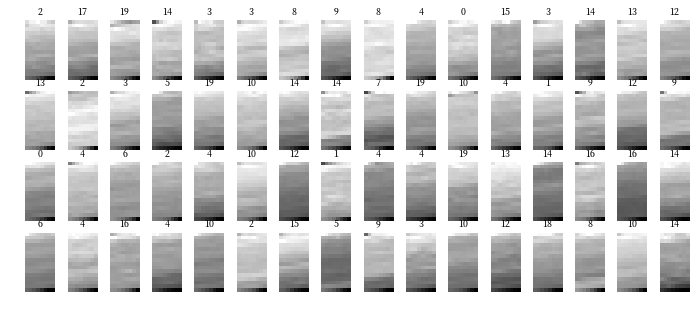

In [5]:
#数据集制作
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1,test_size = 0.05)
print('训练集的大小',len(X_train))
print('测试集的大小',len(X_test))

X_train = X_train.reshape(-1, 1, 16, 8)
Y_train = np.asarray(Y_train,'int64')
X_test = X_test.reshape(-1, 1, 16, 8)

X_train = torch.tensor(X_train)
Y_train = torch.tensor(Y_train,dtype = torch.int64)
train_data = Data.TensorDataset(X_train, Y_train)
X_test = torch.tensor(X_test)
Y_test = torch.tensor(Y_test,dtype = torch.int64)
test_data = Data.TensorDataset(X_test,Y_test)
## 定义一个数据加载器
train_loader = Data.DataLoader(
    dataset = train_data, ## 使用的数据集
    batch_size=128, # 批处理样本大小
    shuffle = False, # 每次迭代前不乱数据 
)

test_loader = Data.DataLoader(
    dataset = test_data, ## 使用的数据集
    batch_size=128, # 批处理样本大小
    shuffle = False, # 每次迭代前不乱数据 
)

for step, (b_x, b_y) in enumerate(train_loader):  
    if step > 0:
        break
print(b_x.shape)
print(b_y.shape)
print(b_x.dtype)
print(b_y.dtype)
## 可视化一个batch的图像
batch_x = b_x.squeeze().numpy()
batch_y = b_y.numpy()
plt.figure(figsize=(12,5))
for ii in np.arange(len(batch_y)):
    plt.subplot(4,16,ii+1)
    plt.imshow(batch_x[ii,:,:],cmap=plt.cm.gray)
    plt.title(batch_y[ii],size = 9)
    plt.axis("off")

In [6]:
#定义模型
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet,self).__init__()
        ## 定义第一个卷积层
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 1,## 输入的feature map
                out_channels = 64,## 输出的feature map
                kernel_size = 3, ##卷积核尺寸
                stride=1,   ##卷积核步长
                padding=5, # 进行填充
            ), ## 卷积后： (1*28*28) ->(16*28*28)
            nn.Tanh(),  # 激活函数
            nn.AvgPool2d(
                kernel_size = 2,## 平均值池化层,使用 2*2
                stride=1,   ## 池化步长为2 
            ), ## 池化后：(16*28*28)->(16*14*14)
        )
        ## 定义第二个卷积层
        self.conv2 = nn.Sequential(
            nn.Conv2d(64,128,3,1,1), 
            nn.Tanh(),  # 激活函数
            nn.AvgPool2d(2,1) 
        )
                ## 定义第二个卷积层
        self.conv3 = nn.Sequential(
            nn.Conv2d(128,256,3,1,1), 
            nn.Tanh(),  # 激活函数
            nn.AvgPool2d(2,1) 
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256,128,3,1,1),
            nn.Tanh(),  # 激活函数
            nn.AvgPool2d(2,1)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128,64,3,1,1),
            nn.Tanh(),  # 激活函数
            nn.AvgPool2d(2,1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(13376,5012),
            nn.Tanh(),
            nn.Dropout(p=0.5),
            nn.Linear(5012,1024),
            nn.Tanh(),
            nn.Dropout(p=0.5),
            nn.Linear(1024,256),
            nn.Tanh(),
            nn.Dropout(p=0.5),
            nn.Linear(256,20),
        )
        self.dropout_c = nn.Dropout(p=0.5)  # dropout训练
        
    ## 定义网络的向前传播路径   
    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout_c(x)
        x = self.conv2(x)
        x = self.dropout_c(x)
        x = self.conv3(x)
        x = self.dropout_c(x)
        x = self.conv4(x)
        x = self.dropout_c(x)
        x = self.conv5(x)
        x = self.dropout_c(x)
        x = x.view(x.size(0), -1) # 展平多维的卷积图层
        # print(x.shape)
        output = self.classifier(x)
        return output

model = MyConvNet()


In [7]:
#训练部分
device = torch.device('cuda')
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
    model.to(device)
print(model)
model = model.to(device)
## 对模型进行训练
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)  
criterion = nn.CrossEntropyLoss()   # 损失函数
num_epochs = 70
train_rate = 0.8

## 计算训练使用的batch数量
batch_num = len(train_loader)
train_batch_num = round(batch_num * train_rate)
## 复制模型的参数
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss_all = []
train_acc_all = []
val_loss_all = []
val_acc_all = []
since = time.time()
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    # 每个epoch有两个训练阶段
    train_loss = 0.0
    train_corrects = 0
    train_num = 0
    val_loss = 0.0
    val_corrects = 0
    val_num = 0
  
    for step,(b_x,b_y) in enumerate(train_loader):
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        model.train() ## 设置模型为训练模式
        optimizer.zero_grad()
        output = model(b_x)     
        pre_lab = torch.argmax(output,1)
        loss = criterion(output, b_y) 
        loss.backward()       
        optimizer.step()  
        train_loss += loss.item() * b_x.size(0)
        train_corrects += torch.sum(pre_lab == b_y.data)
        train_num += b_x.size(0)
    for step,(b_x,b_y) in enumerate(test_loader):
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        model.eval() ## 设置模型为训练模式评估模式
        output = model(b_x)     
        pre_lab = torch.argmax(output,1)
        loss = criterion(output, b_y)  
        val_loss += loss.item() * b_x.size(0)
        val_corrects += torch.sum(pre_lab == b_y.data) 
        val_num += b_x.size(0)
    ## 计算一个epoch在训练集和验证集上的的损失和精度
    train_loss_all.append(train_loss / train_num)
    train_acc_all.append(train_corrects.double().item()/train_num)
    val_loss_all.append(val_loss / val_num)
    val_acc_all.append(val_corrects.double().item()/val_num)
    print('{} Train Loss: {:.4f}  Train Acc: {:.4f}'.format(
        epoch, train_loss_all[-1], train_acc_all[-1]))
    print('{} Val Loss: {:.4f}  val Acc: {:.4f}'.format(
        epoch, val_loss_all[-1], val_acc_all[-1]))
    # 拷贝模型最高精度下的参数
    if  val_acc_all[-1] > best_acc:
        best_acc = val_acc_all[-1]
        best_model_wts = copy.deepcopy(model.state_dict())
    time_use = time.time() - since
    print("Train and val complete in {:.0f}m {:.0f}s".format(
        time_use // 60, time_use % 60))
# 使用最好模型的参数
model.load_state_dict(best_model_wts)
#torch.save(model,'./cnn.pkl')


MyConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(5, 5))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=1, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=1, padding=0)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=1, padding=0)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=1, padding=0)
  )
  (conv5): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=1, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=13376, out_features=5012, bias=True)
    (1): Tanh()
    (2): D

<All keys matched successfully>

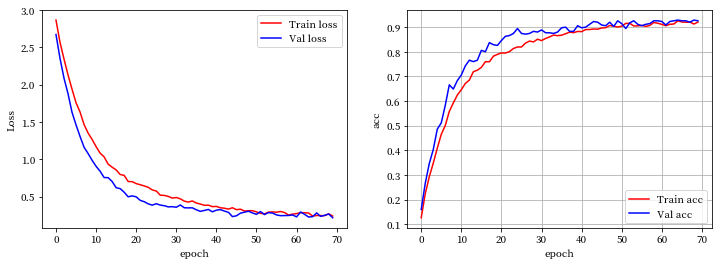

In [9]:
train_process = pd.DataFrame(
    data={"epoch":range(num_epochs),
          "train_loss_all":train_loss_all,
          "val_loss_all":val_loss_all,
          "train_acc_all":train_acc_all,
          "val_acc_all":val_acc_all})

## 可视化模型训练过程
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_process.epoch,train_process.train_loss_all,
         "r-",label = "Train loss")
plt.plot(train_process.epoch,train_process.val_loss_all,
         "b-",label = "Val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(train_process.epoch,train_process.train_acc_all,
         "r-",label = "Train acc")
plt.plot(train_process.epoch,train_process.val_acc_all,
         "b-",label = "Val acc")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.grid()
plt.show()

## 4.模型预测

In [ ]:
!wget http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531887/test_b.zip

In [ ]:
!unzip -qq test_b.zip
!\rm test_b.zip

In [10]:
test_dir = './test_b'
def extract_features(test_dir, file_ext="*.wav"):
    feature = []
    for fn in tqdm(glob.glob(os.path.join(test_dir, file_ext))[:]): # 遍历数据集的所有文件
        X, sample_rate = librosa.load(fn,res_type='kaiser_fast')
        mel = librosa.feature.melspectrogram(y=X,sr=sample_rate)
        mels = np.mean(librosa.power_to_db(mel).T,axis=0) # 计算梅尔频谱(mel spectrogram),并把它作为特征
        #X, sample_rate = librosa.load(fn,res_type='kaiser_fast')
        #mels = np.mean(librosa.feature.melspectrogram(y=X,sr=sample_rate).T,axis=0) # 计算梅尔频谱(mel spectrogram),并把它作为特征
        feature.extend([mels])
    return feature
X_test = extract_features(test_dir)


100%|██████████| 2000/2000 [03:21<00:00,  9.93it/s]


In [11]:
X_test = torch.tensor(np.vstack(X_test))
X_test = X_test.to(device)
predictions = model(X_test.reshape(-1,1, 16, 8)).cpu()

preds = np.argmax(predictions.detach().numpy(), axis = 1)
preds = [label_dict_inv[x] for x in preds]

path = glob.glob('./test_b/*.wav')
result = pd.DataFrame({'name':path, 'label': preds})

result['name'] = result['name'].apply(lambda x: x.split('/')[-1])
result.to_csv('./submit.csv',index=None)

In [ ]:
!nvidia-smi


[AMP INFO][Frontend.cpp:152][1622804033:833819]pid=1152, start to allocate gpu resource ...
Fri Jun  4 18:53:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:08.0 Off |                    0 |
| N/A   54C    P0   219W / 300W |   9465MiB / 16160MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+--------------------

In [27]:
torch.cuda.empty_cache()